# Implementation of object discovery mode in ISA

I would like to implement object discovery (OD) into our ISA. This is the working notebook to figure out how!

The main idea:

- $loss = MSE = (X-X_{slots})^2$
- with $X_{slots} = \sum att_i \cdot \alpha_i \cdot X$  with $X \in [bs, 32, 32]$ original picture, $\alpha \in [bs, 3]$ for 3 slots, $att \in [bs, 3, 32, 32]$
- $\alpha$  tells whether a slot is background or not
- $\alpha$  is learned by a small network $\alpha = miniNetwork(q_i)$ (reminder $q_i$ is queries = slots $\in [bs, 128, 32, 32]$)

Wuhu, this is my first unsupervised training ever!! Let's get started! :-) 

# How to to this

Let's first try to move all the training etc into this notebook so I can play around :-) 

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('./../../code')

from plotting import plot_kslots, plot_kslots_iters
from data_scclevr import makeRings 
from model import InvariantSlotAttention

from matplotlib.patches import Circle
import json

# Set numpy seed for test set sampling 
np.random.seed(24082023)

%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn.functional as F

In [3]:
from scipy.optimize import linear_sum_assignment

In [4]:
from plotting import plot_chosen_slots, plot_kslots, plot_kslots_iters, plot_kslots_grads

In [5]:
torch_seed = 24082023
torch.manual_seed( torch_seed )

import random
random.seed(torch_seed)

In [6]:
device = 'cpu'
cID_prev = 'isa-alpha3_scclevr'
with open(f'./../../code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)

hps = cd['hps']
hps['device'] = device

In [7]:
model = InvariantSlotAttention(**hps).to(device)

In [8]:
model

InvariantSlotAttention(
  (dataN): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (queryN): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (toK): Linear(in_features=16, out_features=128, bias=True)
  (toV): Linear(in_features=16, out_features=128, bias=True)
  (gru): GRUCell(128, 128)
  (CNN_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
  )
  (dense): Linear(in_features=2, out_features=128, bias=True)
  (init_mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (final_mlp): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3, bias=Tru

In [13]:
Ntrain = 5000 
bs=32 
lr=3e-4
warmup_steps=5_000
alpha=1
losses = {'tot':[],'bce':[],'mse':[]}
kwargs={'isRing': True, 'N_clusters':2}
clip_val = 1
device='cpu'
plot_every=20 
save_every=1000
color='C0'
cmap='Blues'

In [8]:
# Learning rate schedule config
base_learning_rate = lr

opt = torch.optim.Adam(model.parameters(), base_learning_rate)
model.train()

k_slots = model.k_slots
max_n_rings = kwargs['N_clusters']
resolution = model.resolution
kwargs['device'] = device
N_obj = kwargs['N_clusters'] # pass to makeRing fct

NameError: name 'model' is not defined

In [11]:
def hungarian_matching(pairwise_cost):
    '''
    Input:
    - pairwise_cost


    Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
    indices = torch.LongTensor(np.array(indices))
    
    loss = 0
    for pi,(ri,ci) in zip(pairwise_cost,indices):
        loss += pi[ri,ci].sum()
    
    return indices 

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
iter 20 , loss 1.013327 , lr 1.1999526265222897e-06


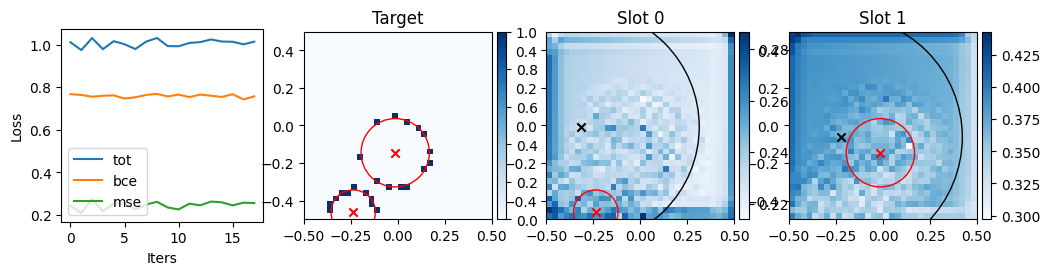

torch.float32
torch.float32


KeyboardInterrupt: 

In [12]:


start = len(losses)
for i in range(start,start+Ntrain):

    learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
    if i < warmup_steps:
        learning_rate *= (i / warmup_steps)
    
    opt.param_groups[0]['lr'] = learning_rate
    
    X, mask, _, Y = makeRings(N_img=bs, N_obj=N_obj, device=device)
    
    queries, att, Y_pred = model(X)
        
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))   
    with torch.no_grad():
        
        att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
        mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 
        
        pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
        
        # pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
        indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)
    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()
    
    Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()

    # Calculate the loss
    li = l_bce + alpha*l_mse
    print(li.dtype)
    
    li.backward()
    clip_val=1
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
    
    opt.step()
    opt.zero_grad()

    losses['tot'].append(float(li))
    losses['bce'].append(float(l_bce))
    losses['mse'].append(float(l_mse))
    
    if i % plot_every == 0:
        print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
        iEvt = 0

        # losses, mask, att_img, Y_true, Y_pred
        plot_chosen_slots(losses,
                            mask[iEvt].sum(axis=0), 
                            slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                            Y_true_sorted[iEvt],
                            Y_pred_sorted[iEvt])
        




In [ ]:
    model.eval()

# Step by step

Ok. This runs. Now do it step by step.

In [18]:
i=1
learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
if i < warmup_steps:
    learning_rate *= (i / warmup_steps)

opt.param_groups[0]['lr'] = learning_rate

X, mask, _, Y = makeRings(N_img=bs, N_obj=N_obj, device=device)

In [19]:
X.shape

torch.Size([32, 1, 32, 32])

Lets use this model for now, but I'll need to change it to include the mini network to learn alpha!

In [20]:
queries, att, Y_pred = model(X)

Now it gets interesting!

In [29]:
dummy_alpha = np.ones((bs, k_slots))
dummy_alpha[:, -1] = 0 # all but last one are signal slots
dummy_alpha = np.expand_dims(dummy_alpha, -1) # reshape from (32, 3) to (32, 3, 1)

In [22]:
X.shape

torch.Size([32, 1, 32, 32])

In [23]:
att.shape

torch.Size([32, 3, 1024])

In [24]:
dummy_alpha.shape

(32, 3, 1)

In [31]:
with torch.no_grad():
    att_signal = att * dummy_alpha
    new_shape = np.array([att_signal.shape[:-1], resolution]).flatten()
    att_signal = np.reshape(att_signal, new_shape)
    #X_reco = np.expand(torch.sum(test*X, axis=1), 1) # why multiply by X???
    X_reco = torch.sum(att_signal, axis=1)[:, None, ::]
    print(X_reco.shape)

torch.Size([32, 1, 32, 32])


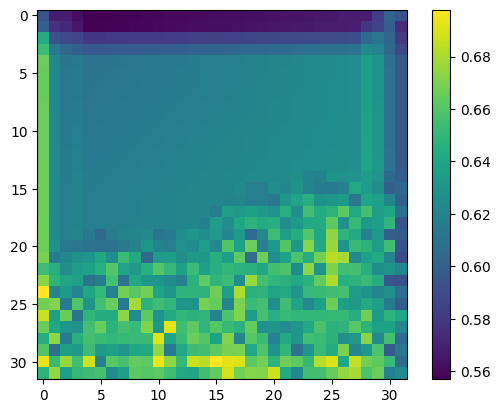

In [32]:
plt.imshow(X_reco[0, 0])
plt.colorbar()
plt.show()

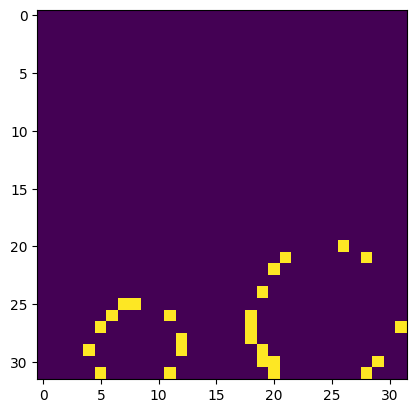

In [33]:
plt.imshow(X[0, 0])
plt.show()

In [34]:
loss = torch.nn.MSELoss(reduction='none')(X, X_reco)
loss.shape


torch.Size([32, 1, 32, 32])

In [35]:
torch.sum(loss, axis=(-1, -2)).shape

torch.Size([32, 1])

In [36]:
l_mse = torch.sum(loss, axis=(-1, -2)).mean()

In [37]:
print(l_mse)

tensor(437.6820, dtype=torch.float64)


**Yeayyyyy!!**

# to summarize 

In [39]:


start = len(losses)
for i in range(start,start+Ntrain):

    learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
    if i < warmup_steps:
        learning_rate *= (i / warmup_steps)
    
    opt.param_groups[0]['lr'] = learning_rate
    
    X, mask, _, Y = makeRings(N_img=bs, N_obj=N_obj, device=device)
    
    queries, att, Y_pred = model(X)
    
    # dummy alpha for now, should be learned by the network!
    dummy_alpha = np.ones((bs, k_slots))
    dummy_alpha[:, -1] = 0 # all but last one are signal slots
    dummy_alpha = np.expand_dims(dummy_alpha, -1) # reshape from (32, 3) to (32, 3, 1)
    
    # compute reconstruced image X_reco
    #with torch.no_grad():
    att_signal = att * torch.FloatTensor(dummy_alpha)
    new_shape = np.array([att_signal.shape[:-1], resolution]).flatten()
    att_signal = torch.reshape(att_signal, tuple(new_shape))
    X_reco = torch.sum(att_signal, axis=1)[:, None, ::] # why multiply by X???  torch.sum(att_signal*X, axis=1)
        
    # loss
    l_mse = torch.nn.MSELoss(reduction='none')(X, X_reco).sum(axis=(-1, -2)).mean()

    # Calculate the loss
    li = l_mse
    
    li.backward()
    clip_val=1
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
    
    opt.step()
    opt.zero_grad()

    losses['mse'].append(float(l_mse))
    
    if i % plot_every == 0:
        print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
        iEvt = 0

        # losses, mask, att_img, Y_true, Y_pred
        plot_chosen_slots(losses,
                            mask[iEvt].sum(axis=0), 
                            slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                            Y_true_sorted[iEvt],
                            Y_pred_sorted[iEvt])
        




iter 20 , loss 460.34592 , lr 1.1999526265222897e-06


NameError: name 'slots_sorted' is not defined

Yeay this is great! 

So what next?

We need to implement a mini network that trains alpha!

In [7]:
class InvariantSlotAttention_disc(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 xlow=-0.5,
                 xhigh=0.5,
                 varlow=0.01,
                 varhigh=0.05,
                 k_slots=3, 
                 num_conv_layers=3,
                 alpha_depth = 32,
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 pixel_mult=1,
                 device='cpu' ,
                 learn_slot_feat=True
                 ):
        '''
        Slot attention encoder block, block attention
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim # dimension after CNN encoder 
        self.query_dim = query_dim # dimension in which slot attention lives
        self.n_iter = n_iter

        self.resolution = resolution
        self.xlow, self.xhigh = xlow, xhigh
        self.rlow, self.rhigh = np.sqrt(varlow), np.sqrt(varhigh)
        
        self.device=device
         
        self.softmax_T = 1/np.sqrt(query_dim)
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)
        
        '''
        CNN feature extractor
        '''
        kwargs = {'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }
        cnn_layers = [torch.nn.Conv2d(1,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
        cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers) # this is CNN model! 
            
        # Grid + query init
        self.abs_grid = self.build_grid()
                   
        self.dense = torch.nn.Linear(2, query_dim) 
        self.pixel_mult = pixel_mult # LH's proposal... but almost same as 1/delta in ISA

        # Apply after the data normalization
        self.init_mlp = torch.nn.Sequential( # what's this for???
            torch.nn.Linear(query_dim,query_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(query_dim,query_dim)
        )
            
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)

        self.init_slots = self.init_slots
        
        '''
        Learn parameter alpha to distinguish signal from background slots
        '''
        self.alpha_mlp = torch.nn.Sequential(
                torch.nn.Linear(query_dim,alpha_depth), #in: query dim (32), out: alpha depth (32)
                torch.nn.ReLU(),
                torch.nn.Linear(alpha_depth, 1),
                torch.nn.Sigmoid()
                #torch.nn.Linear(alpha_depth, 2),
                #torch.nn.Softmax(dim=2) # dim: addiational dimension??? ouput should be something like (bs, N_obj+1) e.g. [[0, 1,1], [], ...]
        )
        
        '''
        Option to add a final (x,y,r) prediction to each slot
        '''
        self.learn_slot_feat = learn_slot_feat
        if self.learn_slot_feat:
            self.final_mlp = torch.nn.Sequential(
                torch.nn.Linear(query_dim,hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, 3)
            )
        
    def build_grid(self):
        '''
        From google slot attention repo:
        https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L357C1-L364C53
        '''
        resolution = self.resolution
        xlow, xhigh = self.xlow, self.xhigh
           
        ranges = [np.linspace(xlow, xhigh, num=res) for res in resolution]
        grid = np.meshgrid(*ranges, sparse=False, indexing="xy")
        grid = np.stack(grid, axis=-1)
        grid = np.reshape(grid, [resolution[0], resolution[1], -1])
        grid = np.expand_dims(grid, axis=0)
        
        grid = torch.FloatTensor( grid ).to(self.device)
        grid = torch.flatten(grid,1,2)
    
        return grid
                
    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        
        stdhigh, stdlow = self.rlow, self.rhigh
        
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)
    
        queries = mu + sigma * torch.randn(mu.shape,device=self.device)
    
        # Add the position and scale initialization for the local ref frame
        ref_frame_dim = 3
        pos_scale = torch.rand(Nbatch, self.k_slots, ref_frame_dim,device=self.device)

        pos_scale[:,:2] -= 0.5
        pos_scale[:,-1]  = (stdhigh - stdlow) * pos_scale[:,-1] + stdlow
        
        return queries, pos_scale
     
    def get_keys_vals(self, encoded_data, pos_scale):

        # Get the relative position embedding
        rel_grid = self.abs_grid.unsqueeze(1) - pos_scale[:,:,:2].unsqueeze(2)
        rel_grid /= pos_scale[:,:,-1].unsqueeze(2).unsqueeze(-1)
        
        # Embed it in the same space as the query dimension 
        embed_grid = self.pixel_mult * self.dense( rel_grid )
        
        # keys, vals: (bs, img_dim, query_dim)
        keys = self.toK(encoded_data).unsqueeze(1) + embed_grid
        vals = self.toV(encoded_data).unsqueeze(1) + embed_grid
        
        keys = self.init_mlp(self.queryN(keys))
        vals = self.init_mlp(self.queryN(vals))
        
        return keys, vals
                
    def attention_and_weights(self,queries,keys):
        
        logits = torch.einsum('bse,bsde->bsd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 1)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def update_frames(self,wts):
        '''
        Update the relative frame position
        '''
        
        # expand to include the batch dim
        grid_exp = self.abs_grid.expand(wts.shape[0],-1,2)
        
        new_pos = torch.einsum('bsd,bde->bse',wts,grid_exp)
        
        new_scale = torch.sum(torch.pow(grid_exp.unsqueeze(1) - new_pos.unsqueeze(2),2),dim=-1)
        
        new_scale = torch.einsum('bsd,bsd->bs', wts, new_scale)
        new_scale = torch.sqrt(new_scale)
        
        return torch.cat([new_pos,new_scale.unsqueeze(-1)],axis=-1)
        
    def iterate(self, queries, pos_scale, encoded_data):
        
        # Get the keys and values in the ref ref frame
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        
        # att,wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),keys)   
        
        new_pos_scale = self.update_frames(wts)
        
        # Update the queries with the recurrent block
        updates = torch.einsum('bsd,bsde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )
        
        return updates.reshape(queries.shape), new_pos_scale
        
    def forward(self, data):
    
        '''
        Step 1: Extract the CNN features
        '''
        encoded_data = self.CNN_encoder(data) # Apply the CNN encoder
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) # Put channel dim at the end
        encoded_data = torch.flatten(encoded_data,1,2) # flatten pixel dims
        encoded_data = self.dataN(encoded_data)
        
        '''
        Step 2: Initialize the slots
        '''
        Nbatch = data.shape[0]
        queries, pos_scale = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
                
        '''
        Step 3: Iterate through the reconstruction
        '''
        for i in range(self.n_iter):
            queries, pos_scale = self.iterate(queries, pos_scale, encoded_data)    
            
        # With the final query vector, calc the attn, weights, + rel ref frames
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        att, wts = self.attention_and_weights(self.queryN(queries),keys)   
        new_pos_scale = self.update_frames(wts)
        
        # learn alpha (signal vs background slot)
        alpha = self.alpha_mlp(queries)
                
        if self.learn_slot_feat:
            slot_feat = self.final_mlp(queries)
            
            # Want to learn the delta from the previously estimated position
            slot_feat += new_pos_scale
            
            return queries, att, slot_feat, alpha 
        
        else:
            return queries, att, wts, alpha

In [8]:
from torch.nn import init

In [9]:
model = InvariantSlotAttention_disc(**hps).to(device)

In [10]:
model

InvariantSlotAttention_disc(
  (dataN): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (queryN): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (toK): Linear(in_features=16, out_features=128, bias=True)
  (toV): Linear(in_features=16, out_features=128, bias=True)
  (gru): GRUCell(128, 128)
  (CNN_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
  )
  (dense): Linear(in_features=2, out_features=128, bias=True)
  (init_mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (alpha_mlp): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bia

In [14]:
# Learning rate schedule config
base_learning_rate = lr

opt = torch.optim.Adam(model.parameters(), base_learning_rate)
model.train()

k_slots = model.k_slots
max_n_rings = kwargs['N_clusters']
resolution = model.resolution
kwargs['device'] = device
N_obj = kwargs['N_clusters'] # pass to makeRing fct

losses = {'mse':[]}

In [17]:


start = len(losses)
for i in range(start,start+Ntrain):

    learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
    if i < warmup_steps:
        learning_rate *= (i / warmup_steps)
    
    opt.param_groups[0]['lr'] = learning_rate
    
    X, mask, _, Y = makeRings(N_img=bs, N_obj=N_obj, device=device)
    
    queries, att, Y_pred, dummy_alpha = model(X)
    print(dummy_alpha.shape)
    # dummy alpha for now, should be learned by the network!
    #dummy_alpha = np.ones((bs, k_slots))
    #dummy_alpha[:, -1] = 0 # all but last one are signal slots
    #dummy_alpha = np.expand_dims(dummy_alpha, -1) # reshape from (32, 3) to (32, 3, 1)
    
    # compute reconstruced image X_reco
    #with torch.no_grad():
    att_signal = att * torch.FloatTensor(dummy_alpha)
    new_shape = np.array([att_signal.shape[:-1], resolution]).flatten()
    att_signal = torch.reshape(att_signal, tuple(new_shape))
    X_reco = torch.sum(att_signal, axis=1)[:, None, ::] # why multiply by X???  torch.sum(att_signal*X, axis=1)
        
    # loss
    l_mse = torch.nn.MSELoss(reduction='none')(X, X_reco).sum(axis=(-1, -2)).mean()

    # Calculate the loss
    li = l_mse
    
    li.backward()
    clip_val=1
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
    
    opt.step()
    opt.zero_grad()

    losses['mse'].append(float(l_mse))
    
    if i % plot_every == 0:
        print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
        iEvt = 0

        # losses, mask, att_img, Y_true, Y_pred
        plot_chosen_slots(losses,
                            mask[iEvt].sum(axis=0), 
                            slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                            Y_true_sorted[iEvt],
                            Y_pred_sorted[iEvt])
        




torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 20 , loss 187.2453 , lr 1.1999526265222897e-06


NameError: name 'slots_sorted' is not defined

### Make plotting function

In [31]:
from matplotlib.patches import Circle

In [19]:
losses

{'mse': [23.05937385559082,
  22.451221466064453,
  24.31821060180664,
  22.82436180114746,
  22.563777923583984]}

In [20]:
X.shape

torch.Size([32, 1, 32, 32])

In [21]:
X_reco.shape

torch.Size([32, 1, 32, 32])

In [22]:
att_signal.shape

torch.Size([32, 3, 32, 32])

In [27]:
Y.shape

torch.Size([32, 2, 3])

In [65]:
Y.shape[1]

2

In [43]:
n_rings

NameError: name 'n_rings' is not defined

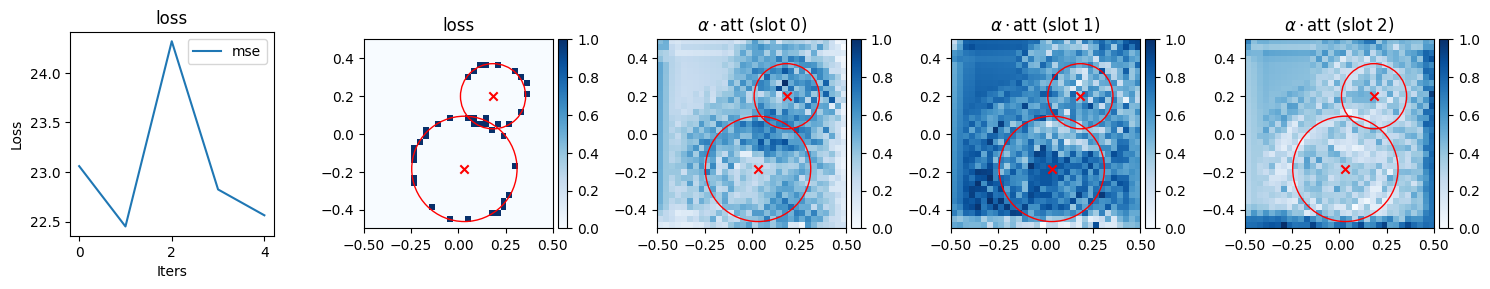

In [64]:
# plot true picture:

i = 2
fig, axs = plt.subplots(1,3+N_obj, figsize=(3*(N_obj + 3) ,3))

# loss
for k,v in losses.items():
    axs[0].plot(v,label=k)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_box_aspect(1)
    axs[0].set_title("loss")

# truth
extent= [-0.5, 0.5]*2
cmap = 'Blues'

img = axs[1].imshow(X[i, 0], origin='lower', cmap=cmap, extent=extent)
axs[1].set_title("loss")
# colorbar:
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax, orientation='vertical')

# rings
for j in range(1, N_obj+3):
    axs[j].scatter(Y[i,:, 0], Y[i,:, 1], marker="x", c='r')
    for yi in Y[i].cpu().numpy():
        circle = Circle(yi[:2],yi[2],fill=False,color='r')
        axs[j].add_patch(circle)

# reco
for k, j in enumerate(range(2, 3+N_obj)):
    axs[j].imshow(att_signal.detach().cpu().numpy()[i, k],  origin='lower', cmap=cmap, extent=extent)
    axs[j].set_title(r"$\alpha \cdot \mathrm{att}$"+" (slot {})".format(k))
    # colorbar:
    divider = make_axes_locatable(axs[j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')



plt.tight_layout()
plt.show()

In [16]:
def plot_slots_with_alpha(losses, X, att_signal, Y, cmap = 'Blues', figname=''):
    N_obj = Y.shape[0]
    fig, axs = plt.subplots(1,3+N_obj, figsize=(3*(N_obj + 3) ,3))

    # loss
    for k,v in losses.items():
        axs[0].plot(v,label=k)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_box_aspect(1)
    #axs[0].set_title("loss")

    # truth
    extent= [-0.5, 0.5]*2

    img = axs[1].imshow(X[0], origin='lower', cmap=cmap, extent=extent)
    axs[1].set_title("Truth")
    # colorbar:
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

    # rings
    for j in range(1, N_obj+3):
        axs[j].scatter(Y[:, 0], Y[:, 1], marker="x", c='r')
        for yi in Y.cpu().numpy():
            circle = Circle(yi[:2],yi[2],fill=False,color='r')
            axs[j].add_patch(circle)
            axs[j].set_ylim(extent[0], extent[1])
            axs[j].set_xlim(extent[0], extent[1])

    # reco
    for k, j in enumerate(range(2, 3+N_obj)):
        axs[j].imshow(att_signal.detach().cpu().numpy()[k],  origin='lower', cmap=cmap, extent=extent)
        axs[j].set_title(r"$\alpha \cdot \mathrm{att}$"+" (slot {})".format(k))
        # colorbar:
        divider = make_axes_locatable(axs[j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='vertical')

    plt.tight_layout()
    if figname:
        plt.savefig(figname)
    plt.show()
    plt.close()

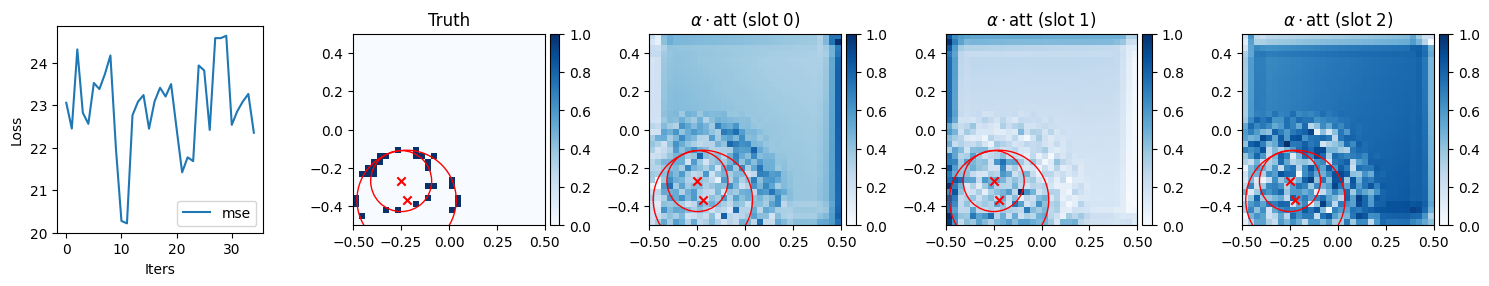

In [80]:
plot_slots_with_alpha(losses, X[i], att_signal[i], Y[i])

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 20 , loss 186.69215 , lr 1.1999526265222897e-06


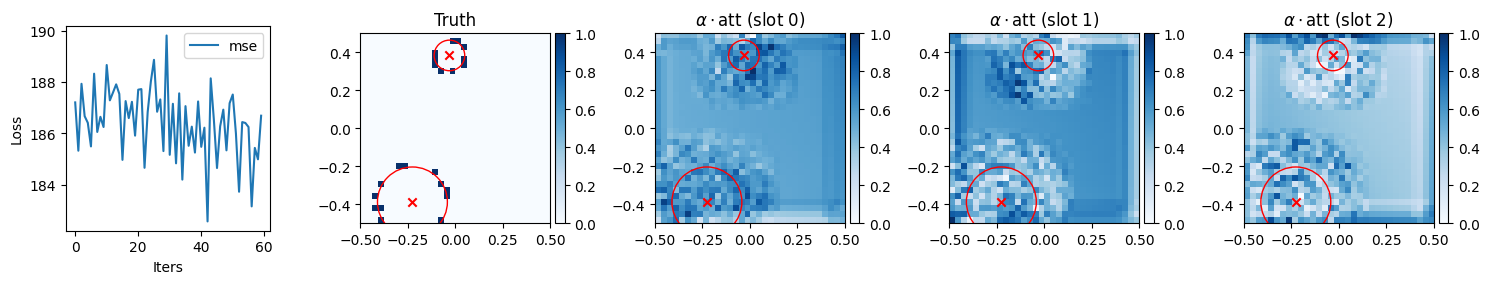

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 40 , loss 181.21303 , lr 2.39962102713996e-06


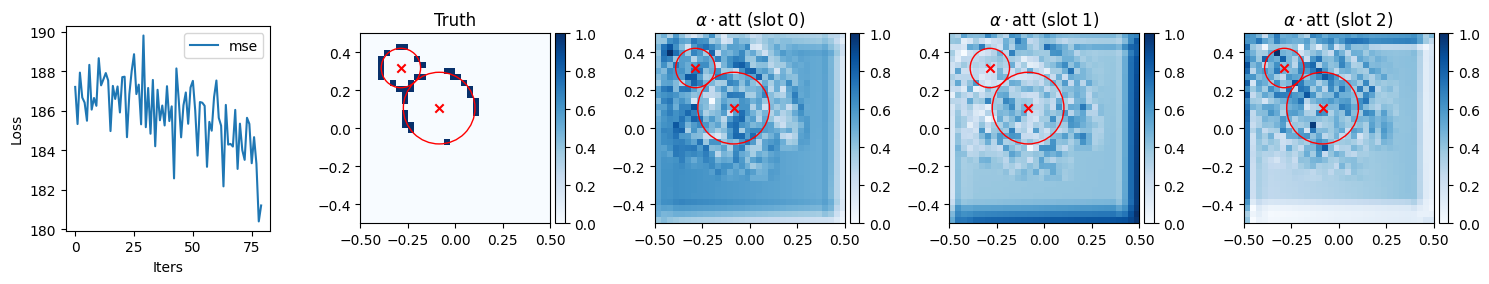

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 60 , loss 180.11784 , lr 3.5987210507530604e-06


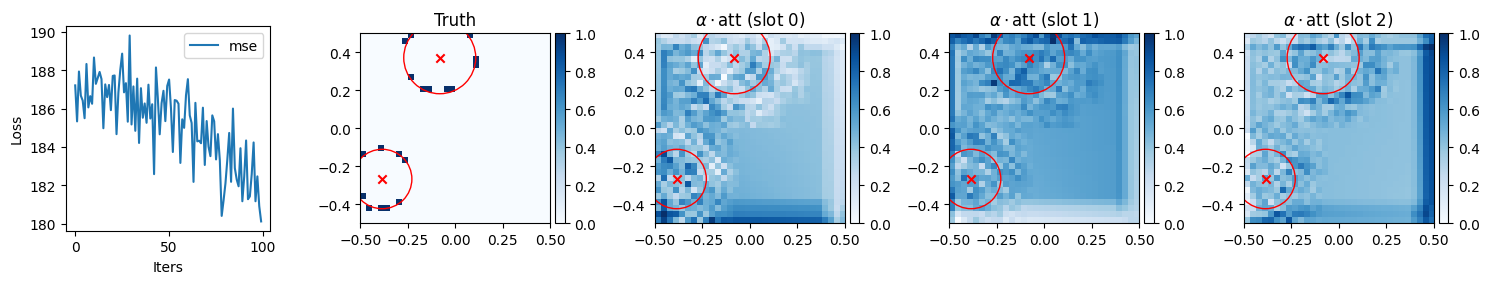

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 80 , loss 174.5329 , lr 4.796968695854442e-06


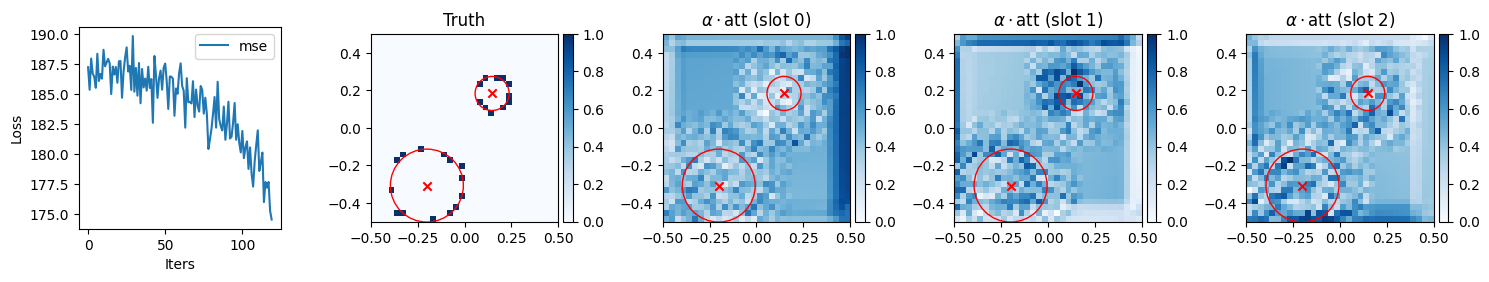

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 100 , loss 171.89877 , lr 5.994080185284814e-06


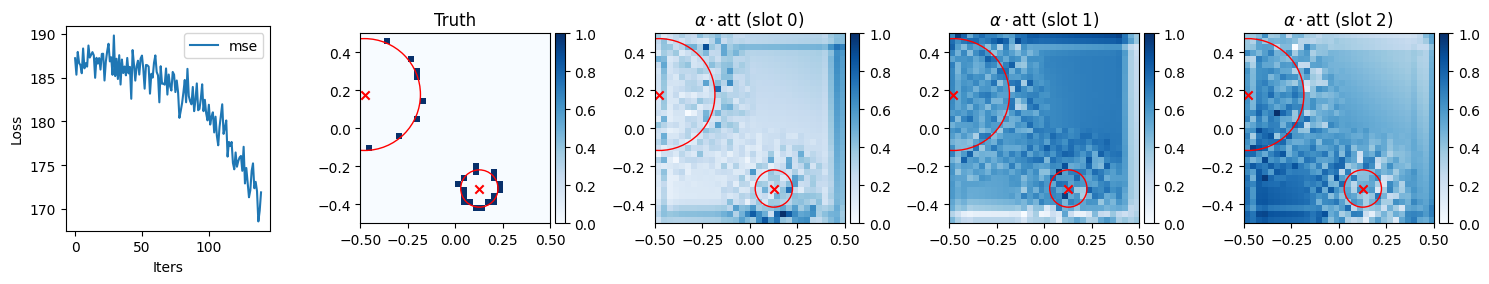

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 120 , loss 164.95822 , lr 7.189772040938209e-06


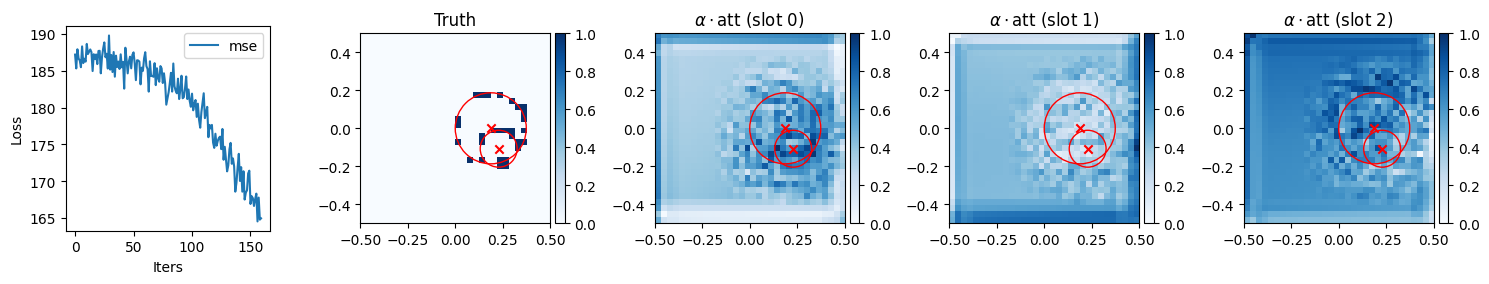

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 140 , loss 152.78262 , lr 8.383761158401323e-06


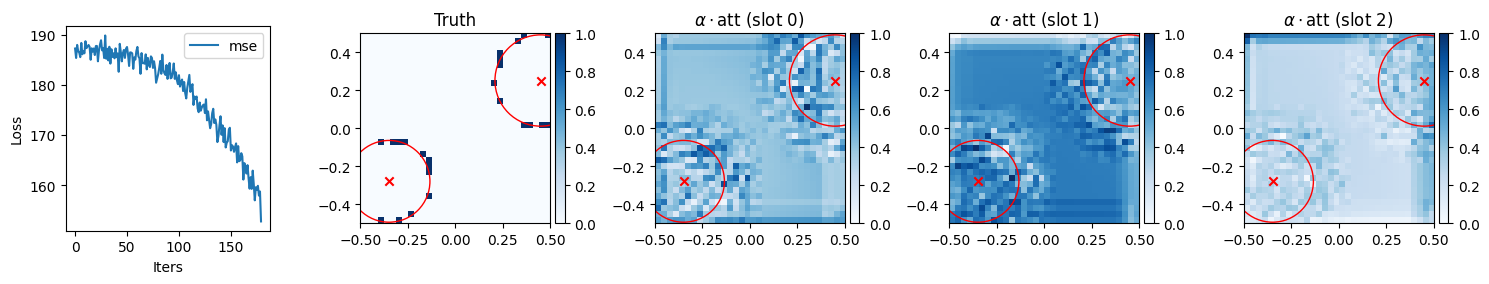

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 160 , loss 147.41228 , lr 9.57576488151024e-06


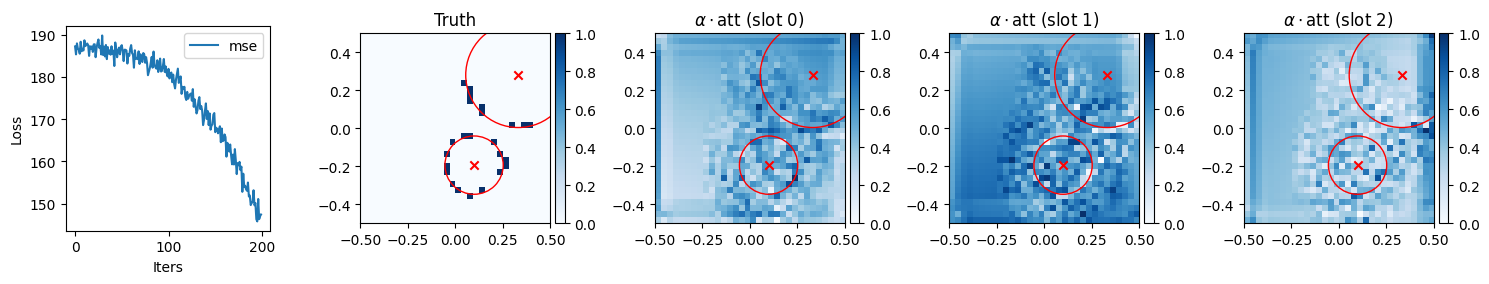

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 180 , loss 132.99707 , lr 1.0765501076808043e-05


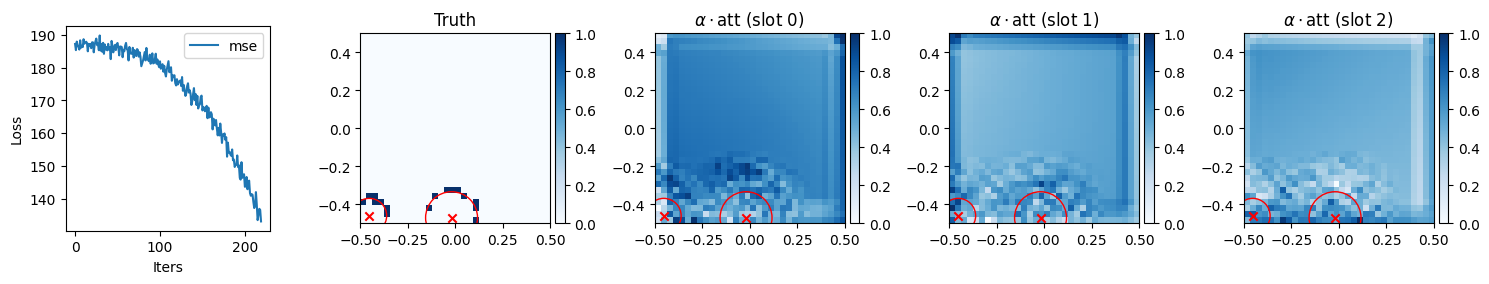

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 200 , loss 120.55657 , lr 1.1952688207886868e-05


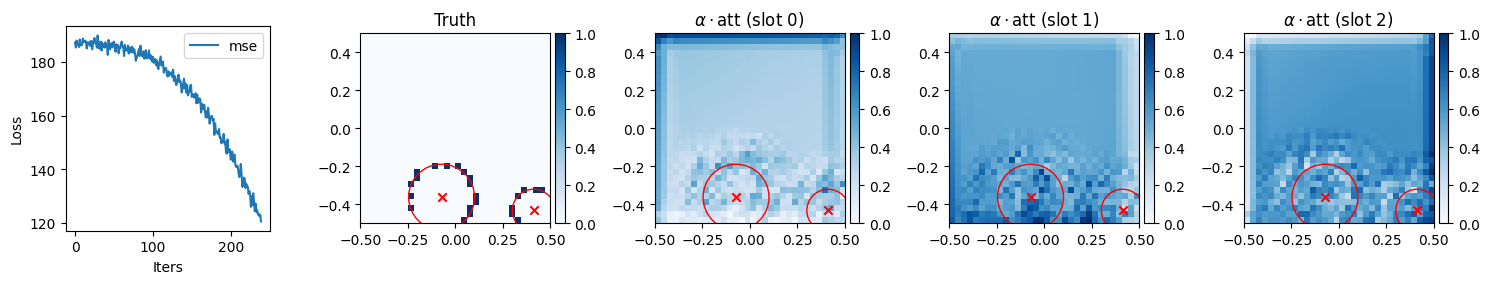

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 220 , loss 106.546486 , lr 1.3137045409597896e-05


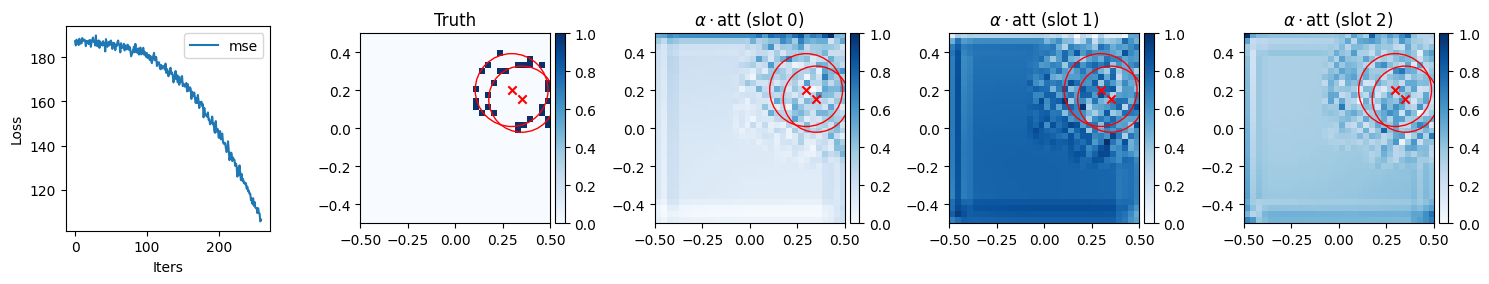

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 240 , loss 91.35496 , lr 1.4318292562112981e-05


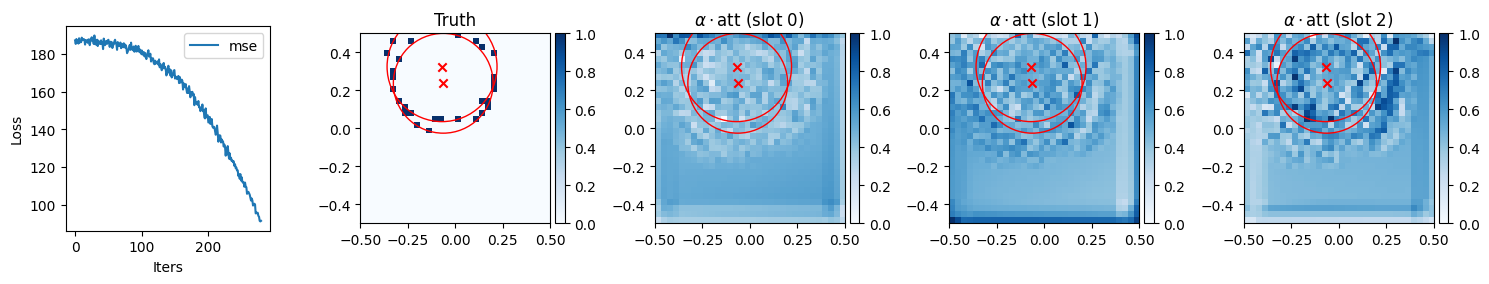

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 260 , loss 76.45521 , lr 1.5496150364821365e-05


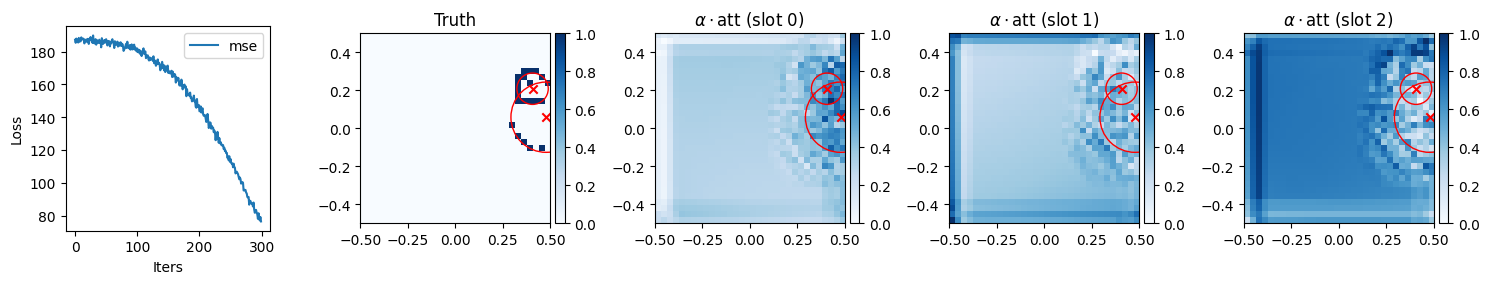

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 280 , loss 61.274254 , lr 1.6670340410045327e-05


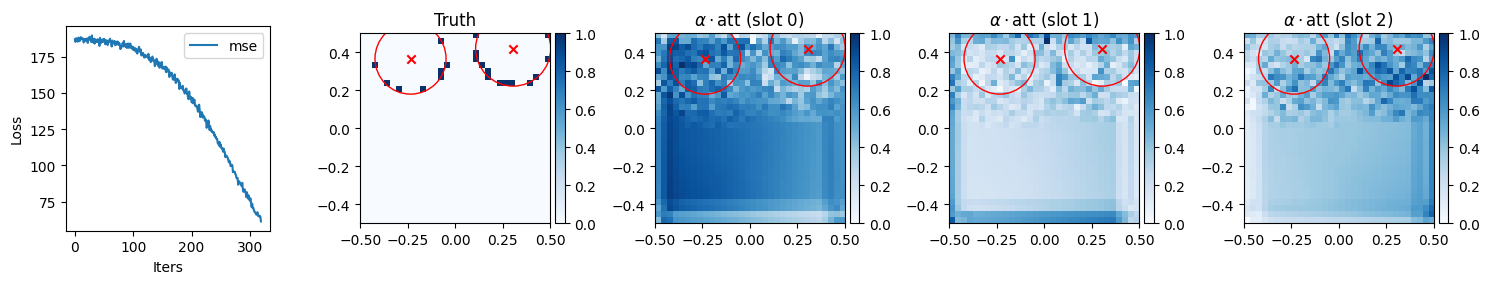

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
iter 300 , loss 48.837585 , lr 1.7840585256558198e-05


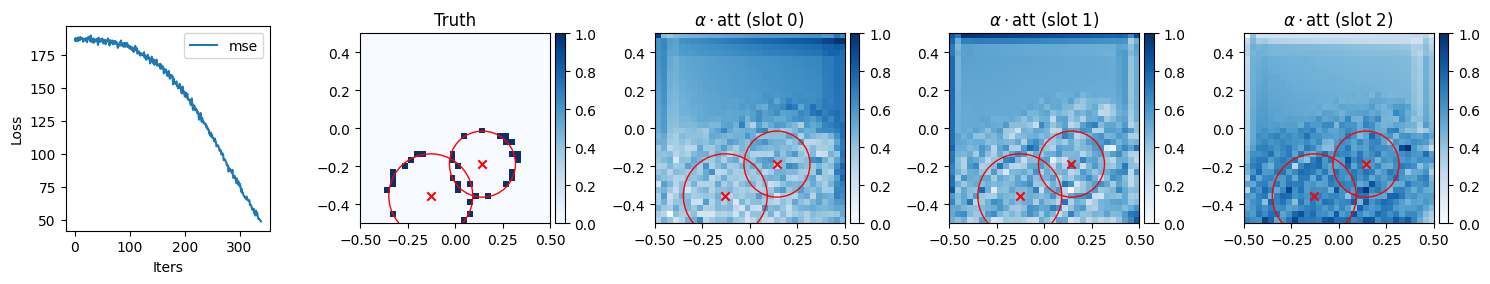

torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])
torch.Size([32, 3, 1])


KeyboardInterrupt: 

In [18]:


start = len(losses)
for i in range(start,start+Ntrain):

    learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
    if i < warmup_steps:
        learning_rate *= (i / warmup_steps)
    
    opt.param_groups[0]['lr'] = learning_rate
    
    X, mask, _, Y = makeRings(N_img=bs, N_obj=N_obj, device=device)
    
    queries, att, Y_pred, dummy_alpha = model(X)
    print(dummy_alpha.shape)
    # dummy alpha for now, should be learned by the network!
    #dummy_alpha = np.ones((bs, k_slots))
    #dummy_alpha[:, -1] = 0 # all but last one are signal slots
    #dummy_alpha = np.expand_dims(dummy_alpha, -1) # reshape from (32, 3) to (32, 3, 1)
    
    # compute reconstruced image X_reco
    #with torch.no_grad():
    att_signal = att * torch.FloatTensor(dummy_alpha)
    new_shape = np.array([att_signal.shape[:-1], resolution]).flatten()
    att_signal = torch.reshape(att_signal, tuple(new_shape))
    X_reco = torch.sum(att_signal, axis=1)[:, None, ::] # why multiply by X???  torch.sum(att_signal*X, axis=1)
        
    # loss
    l_mse = torch.nn.MSELoss(reduction='none')(X, X_reco).sum(axis=(-1, -2)).mean()

    # Calculate the loss
    li = l_mse
    
    li.backward()
    clip_val=1
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
    
    opt.step()
    opt.zero_grad()

    losses['mse'].append(float(l_mse))
    
    if i % plot_every == 0:
        print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
        iEvt = 0

        # losses, mask, att_img, Y_true, Y_pred
        plot_slots_with_alpha(losses, X[iEvt], att_signal[iEvt], Y[iEvt])
        


